# MOVIES MOVIES MOVIES !!!

Movies have existed for well over a century. But in that time they have evolved and changed greatly. In this project, we are looking through various movie trends and what has changed over the years. We use various python tools and libraries to give us more information about our data. 

In [131]:
import requests
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from statsmodels.formula import api as stats
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

## Step 1: Data Collection

We start by collecting some data from IMDB. We have two data sets that we want to use, the basics and ratings one. The basics will give general information about our movies such as runtime, year, genre etc. The ratings will provide us with the average movie rating on a scale of 10 and number of votes per rating. We request and download this data and then write it to our directories. 

In [130]:
# downloading the data. These are datasets provided for non-commercial use
url= 'https://datasets.imdbws.com/title.basics.tsv.gz';
url2= 'https://datasets.imdbws.com/title.ratings.tsv.gz';

titledata= requests.get(url);
ratingdata= requests.get(url2);

title_filename= 'title_data.tsv.gz';
ratings_filename= 'ratings.tsv.gz';

# write the files to our directory
open(title_filename, 'wb').write(titledata.content);
open(ratings_filename, 'wb').write(ratingdata.content);

KeyboardInterrupt: 

In [ ]:
# reading the data into panda dataframes
title_df= pd.read_csv(title_filename, sep="\t", compression="gzip", dtype={'isAdult': str});
ratings_df= pd.read_csv(ratings_filename, sep="\t", compression="gzip");
print(title_df.head(5), ratings_df.head(5))

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short         tconst  averageRating  numVotes
0  tt0000001            5.7      1971
1  tt0000002            5.8       263
2  tt0000003   

Now we collect some more data. We import box office data as well to get a better idea of how factors affect the box office success of movies. We employ a similar process to our data collection above except we have to iterate through 200 ranks at a time to scrape the data. 

In [ ]:
#move this to data collection section
# original url with no offset on 
box_office_url = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset='
box_office_df = pd.DataFrame()
# iterate over each webpage 200 ranks at a time
for i in range(0,1000,200):
    # append the offset to the url
    box_req = requests.get(box_office_url + str(i))
    soup = BeautifulSoup(box_req.content, 'html.parser')
    # add the next 200 ranks to the current 
    box_office_df = pd.concat([box_office_df, pd.read_html(io=str(soup.find('table')))[0]])
box_office_df.head(10)

Rename the 'Title' column to 'primaryTitle' to merge with the original dataframe

In [ ]:
box_office_df.rename(columns={'Title': 'primaryTitle'},inplace=True)

Now we take our data and put it into a dataframe. We use the pandas library to read it in. Pandas is an extremely powerful library. We use it above to read in a csv file, but it can be used for many more sitautions. Refer to the API Reference page (https://pandas.pydata.org/docs/reference/) for full details.

## Step 2: Data Processing

Now we join our data into one dataframe. This allows us to easily compare the data across both files. We are able to use inner join and use 'tconst'. 'tconst' is a unique identifier for each piece of media making it very easy for us to join the two tables. To learn more about joins visit https://pandas.pydata.org/docs/user_guide/merging.html.

In [ ]:
# when u remove and clean values
df = pd.merge(left=title_df, right=ratings_df, on='tconst', how='inner')

In [ ]:
df.drop(labels=['endYear'],axis=1, inplace=True)

In [ ]:
df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.7,1971
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short",5.8,263
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1817
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short",5.6,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.2,2613


We need to parse certain columns to integers

In [ ]:
df.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult            object
startYear          object
runtimeMinutes     object
genres             object
averageRating     float64
numVotes            int64
dtype: object

In our dataset, there were all sorts of forms of media. Here we are only looking at movies so we can drop all other forms of media (short films, shows, ...). We are analyzing these movies over time thus, so we can also drop any movies without a release date ('startYear'). Then, we need to convert the release dates from strings to integers in order to plot them later on.

In [ ]:
# keep only movies
df = df[df['titleType'] == 'movie']
# drop movies without a release date
df = df[df['startYear'] != '\\N']
# convert release date from strings to integers
df['startYear'] = df['startYear'].apply(int)

In [ ]:
# 1 if isAdult else, if it's any other value (0 or invalid)
function = lambda x: True if x == '1' else False
df['isAdult'] = df['isAdult'].apply(function)

In [ ]:
df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.3,204
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,100,"Documentary,News,Sport",5.3,469
326,tt0000502,movie,Bohemios,Bohemios,False,1905,100,\N,4.1,15
358,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Action,Adventure,Biography",6.0,826
366,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,90,Drama,4.4,20


## Step 3: Exploratory Analysis and Data Vizualization

### Amount of movies

Let's look at how many movies were produced every year. Then we can plot it as a histogram with each bin counting 5 years worth of data.

(array([4.0000e+00, 9.0000e+00, 4.5000e+01, 2.9500e+02, 1.2290e+03,
        1.4880e+03, 2.0040e+03, 3.3950e+03, 4.9940e+03, 4.9030e+03,
        4.0460e+03, 5.5440e+03, 6.6400e+03, 7.4880e+03, 8.7680e+03,
        1.0978e+04, 1.0963e+04, 1.1720e+04, 1.2835e+04, 1.2710e+04,
        1.3396e+04, 1.7296e+04, 2.5547e+04, 3.8393e+04, 5.8723e+04]),
 array([1894, 1899, 1904, 1909, 1914, 1919, 1924, 1929, 1934, 1939, 1944,
        1949, 1954, 1959, 1964, 1969, 1974, 1979, 1984, 1989, 1994, 1999,
        2004, 2009, 2014, 2019]),
 <BarContainer object of 25 artists>)

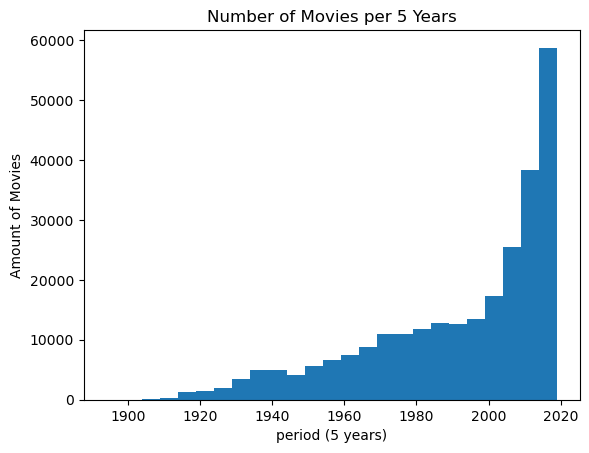

In [ ]:
# count of movies for each year
years = df['startYear']
# create bins of size 5 starting 
bins = np.arange(start=df['startYear'].min(),stop=df['startYear'].max(),step=5)
plt.xlabel('period (5 years)')
plt.ylabel('Amount of Movies')
plt.title(label='Number of Movies per 5 Years')
plt.hist(x=years,bins=bins)

Observe as time progressed more and more movies were created. From the late 1800s to the late 1910s the camera and filming technology was very limited making it difficult to produce movies. Then, as the technology to film and store movies became more advance the demand to watch those movies also grew causing more to be produced. 

### Runtime

Next, let's look at the runtimes of movies over the years.

In [ ]:
#Drop null values and store runtime by year
by_year = df.dropna(axis=0,subset='runtimeMinutes').groupby(by='startYear')

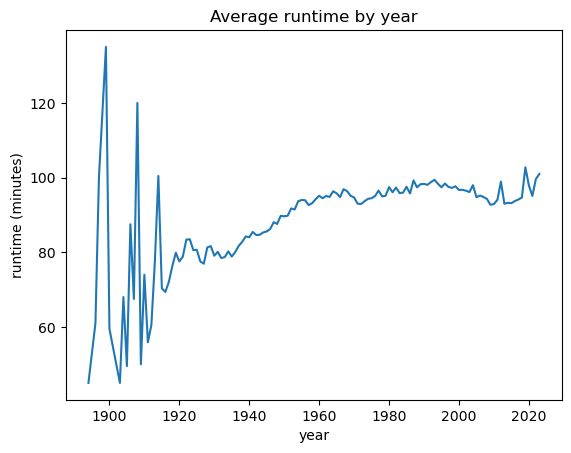

In [ ]:
#Find average runtime of each year and plot it
avgs = by_year['runtimeMinutes'].mean()
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Average runtime by year')
plt.plot(avgs)

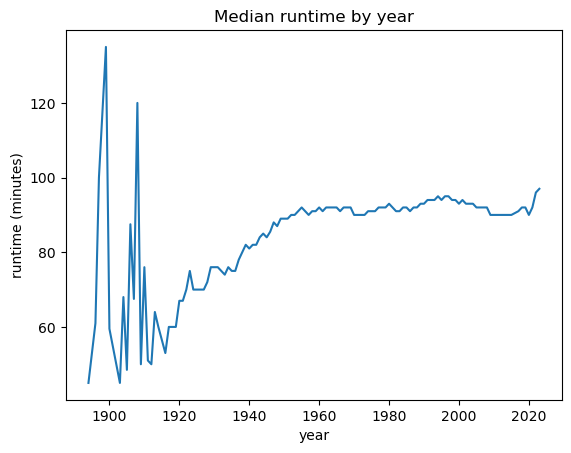

In [ ]:
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Median runtime by year')
plt.plot(by_year['runtimeMinutes'].median())

The average and median runtimes of movies has a clear positive trend initially and then, flattened out to about 90 minutes. In the early 20th century, there were barely any movies thus, it was much more sensitive to outliers. Then, as more movies were produced, the runtime stabilized and followed a trend over the years. Similar to the quantity of movies, it could be that movies grew in length partially due to better techonolgy until moviemakers decided 90 minutes is a good balance of time to both tell a complete story and keep the audience's attention. 

### Genres

Now let us take a look at the various genres of movies made over time. 

Text(0.5, 1.0, 'Frequency of Genres by Year')

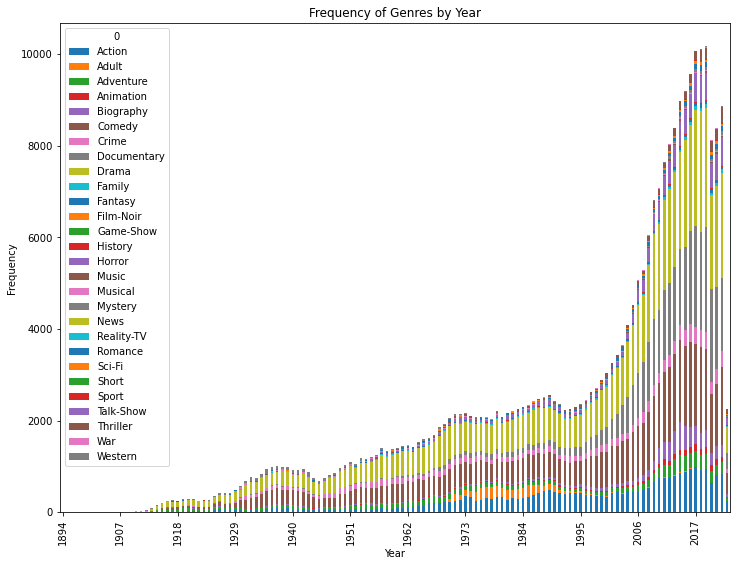

In [138]:
#This block is looking at the frequency of genre over time
#The first step is to split a data cell of a movie with multiple genres into separate cells
genre = df['genres'].str.split(",", n=2, expand = True)
#Then we add in year into our new dataframe
genre.insert(3, "year", df['startYear'], True)
#We delete NaN and Null values
genre = genre[genre[0] != '\\N']
#We drop the secondary and tertiary genres as we are only looking at the primary genre
genre.drop([1, 2], axis=1)
#We then group the genre by year and put it in a data frame
genre_tot = genre[[0, 'year']].groupby('year')[0].value_counts().reset_index(name='count')
#Now we plot our data in a stacked bar graph
genre.groupby(['year', 0]).size().unstack().plot.bar(stacked=True, figsize=(12, 9))
#We set 12 x ticks
plt.locator_params(axis='x', nbins=12)
#We label our graph
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Frequency of Genres by Year")


In this block, we separated the genres and found a count of them for each year. We then used that data to plot a stacked bar chart. The bar chart function allows a number of arguments allowing advanced pandas users to have great customizability. For more details specifically about stacked bar charts visit https://www.statology.org/pandas-stacked-bar-chart/.

Here we had to first clean up the genre cells. These cells oftentimes had multiple genres listed with a comma separating each genre. We separated the genres and looked at primary genres to keep all movies on an even playing field. The graph shows how the sheer quantity of movies have grown. One genre that peaked in the 21st century is comedies. Action movies also grew from the mid 20th century onwards. Dramas and documentaries followed a similar path growing over time as well. Musicals have stayed relatively stagnant as other genres have grown. This may be because of the difficult nature to making a good musical. It requires good storytelling along with music composition. As it has become a lot easier to write and produce small budget movies of other genres with new and better technology, writing a musical remains a tough task.

In [ ]:
df.sort_values(by=['numVotes'], ascending=False).head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
82553,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2737197
250352,tt0468569,movie,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2710299
637705,tt1375666,movie,Inception,Inception,False,2010,148,"Action,Adventure,Sci-Fi",8.8,2405897
99038,tt0137523,movie,Fight Club,Fight Club,False,1999,139,Drama,8.8,2179464
81458,tt0109830,movie,Forrest Gump,Forrest Gump,False,1994,142,"Drama,Romance",8.8,2130000
82336,tt0110912,movie,Pulp Fiction,Pulp Fiction,False,1994,154,"Crime,Drama",8.9,2103444
96890,tt0133093,movie,The Matrix,The Matrix,False,1999,136,"Action,Sci-Fi",8.7,1952567
90337,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,False,2001,178,"Action,Adventure,Drama",8.8,1911215
46207,tt0068646,movie,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1903471
395431,tt0816692,movie,Interstellar,Interstellar,False,2014,169,"Adventure,Drama,Sci-Fi",8.6,1901239


## Analysis, Hypothesis Testing, and Machine Learning

In [ ]:
# more in depth, test hypotheses coming from the graphs

## Insight and Policy Decision

## Conclusion